# Quick Start Tutorial
This notebook is meant to demonstrate basic usage of the beep package with data from "Data-driven prediction of battery cycle life before capacity degradation" KA Severson, et al. Nature Energy 4 (5), 383-391

This data is available for download from https://data.matr.io/1/ . For brevity, only one test is included in this notebook but the example can easily be extended to a larger number of files.

In [2]:
!pip install beep

    100% |████████████████████████████████| 112kB 5.0MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 18.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.7MB 12.2MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 27.5MB/s ta 0:00:01
    100% |████████████████████████████████| 20.2MB 2.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 266kB 36.9MB/s ta 0:00:01
    100% |████████████████████████████████| 512kB 31.9MB/s ta 0:00:01
    100% |████████████████████████████████| 235kB 40.4MB/s ta 0:00:01
    100% |████████████████████████████████| 10.1MB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 30.8MB/s ta 0:00:01
    100% |████████████████████████████████| 5.9MB 9.1MB/s eta 0:00:01
    100% |████████████████████████████████| 133kB 41.3MB/s ta 0:0

## BEEP imports
The main modules used in the data pipeline are `validate`, `structure`, and `featurize`. Development of the `featurize` and `run_model` modules are ongoing since they represent the scientific research into the mechanisms of battery degradation and the goals of prediction.
The data structure uses the `MSONable` data format from `monty` which is close to json, but allows the package to store pandas dataframes with characters that are not allowed in standard json format. 

In [53]:
import requests
import os
import numpy as np
import pandas as pd
from monty.json import MSONable
from monty.serialization import loadfn, dumpfn
from scipy.stats import skew
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
%env BEEP_ENV=dev
%env BEEP_PROCESSING_DIR=tutorial
from beep import validate, structure, featurize, run_model, generate_protocol
import json
import glob

env: BEEP_ENV=dev
env: BEEP_PROCESSING_DIR=tutorial


## File Download
The example data set we are using here comes from a set of A123 LFP cells cycled under fast charge conditions. While cell is configured for downloading a single cell, its also possible to download the entire data set and run all of the processing steps on all of the data. Note that for Arbin files, it is necessary to have the metadata file in addition to the data file in order to perform the data structuring correctly.


In [54]:
print('Beginning file download with requests')
data_dir = './Severson-et-al/'

try:
    os.makedirs(data_dir)
except FileExistsError:
    pass

url = 'https://data.matr.io/1/api/v1/file/5c86c0bafa2ede00015ddf70/download'
r = requests.get(url)

with open(os.path.join(data_dir, '2017-05-12_6C-50per_3_6C_CH36.csv'), 'wb') as f:
    f.write(r.content)
    
url = 'https://data.matr.io/1/api/v1/file/5c86c0b5fa2ede00015ddf6d/download'
r = requests.get(url)

with open(os.path.join(data_dir, '2017-05-12_6C-50per_3_6C_CH36_Metadata.csv'), 'wb') as f:
    f.write(r.content)

# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

Beginning file download with requests
200
text/csv
ISO-8859-1


## Data pipeline
This cell creates a list of all of the files in the data directory and then runs the data pipeline processing steps on each of the files.

#### Validation
This module determine if the data conforms to expected format with the correct column names and with values inside an expected range.

#### Structuring
The structuring module turns the time series data from the cycler machine into a json-like structure with DataFrame objects. The DataFrame objects include a summary DataFrame with per cycle statistics, and a DataFrame with interpolated charge and discharge steps of the regular cycles. For files that have diagnostic cycles that were programmatically inserted, separate DataFrame objects are created with summary statistics and interpolated steps for the diagnostic cycles.

#### Featurization
Featurization uses the structured objects to calculate statistically and physically relevant quantities for the purpose of building predictive machine learning models. The objects can be selected and joined for the purposes of training the model, or used for predicting individual outcomes.

In [55]:
data_dir = './Severson-et-al/'
file_list = glob.glob(os.path.join(data_dir, '*[0-9].csv'))

mode = 'events_off'
mapped  =  {
            "mode": 'events_off',  # mode run|test|events_off
            "file_list": file_list,  # list of file paths ['path/test1.csv', 'path/test2.csv']
            'run_list': list(range(len(file_list)))  # list of run_ids [0, 1]
            }
mapped = json.dumps(mapped)
# Validation
validated = validate.validate_file_list_from_json(
    mapped)
validated_output = json.loads(validated)
validated_output['mode'] = mode  # mode run|test|events_off
validated_output['run_list'] = list(range(len(validated_output['file_list'])))
validated = json.dumps(validated_output)

print(validated)

# Data structuring
structured = structure.process_file_list_from_json(
    validated)
structured_output = json.loads(structured)
structured_output['mode'] = mode  # mode run|test|events_off
structured_output['run_list'] = list(range(len(file_list)))
structured = json.dumps(structured_output)

print(structured)

# Featurization
featurized = featurize.process_file_list_from_json(
    structured)
featurized_output = json.loads(featurized)
featurized_output['mode'] = mode  # mode run|test|events_off
featurized_output['run_list'] = list(range(len(file_list)))
featurized = json.dumps(featurized_output)

print(featurized)

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


{"file_list": ["./Severson-et-al/2017-05-12_6C-50per_3_6C_CH36.csv"], "run_list": [0], "validity": ["valid"], "message_list": [{"comment": "", "error": ""}], "mode": "events_off"}


100%|██████████| 877/877 [02:08<00:00,  6.84it/s]


{"file_list": ["/home/ec2-user/SageMaker/tutorial/data-share/structure/2017-05-12_6C-50per_3_6C_CH36_structure.json"], "run_list": [0], "result_list": ["success"], "message_list": [{"comment": "", "error": ""}], "invalid_file_list": [], "mode": "events_off"}
{"file_list": ["/home/ec2-user/SageMaker/tutorial/data-share/features/DeltaQFastCharge/2017-05-12_6C-50per_3_6C_CH36_features_DeltaQFastCharge.json", "/home/ec2-user/SageMaker/tutorial/data-share/features/TrajectoryFastCharge/2017-05-12_6C-50per_3_6C_CH36_features_TrajectoryFastCharge.json"], "run_list": [0], "result_list": ["success", "success"], "message_list": [{"comment": "", "error": ""}, {"comment": "", "error": ""}], "mode": "events_off"}


### Interpolated cycles
The code below demonstrates how to access the DataFrame objects in the structure file. Loading the file is substantially faster than analyzing the raw time series data. The interpolated data also provides the ability to calculate differences between cycles.

4.6974263191223145
876
1.1737735
1.1737735


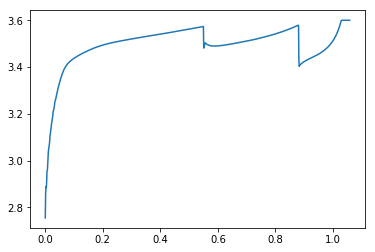

In [56]:
processing_dir = %env BEEP_PROCESSING_DIR
struct = loadfn(os.path.join(processing_dir, 'data-share', 'structure', '2017-05-12_6C-50per_3_6C_CH36_structure.json'))
reg_charge = struct.cycles_interpolated[struct.cycles_interpolated.step_type == 'charge']
print(reg_charge.current[reg_charge.cycle_index == 25].mean())
print(reg_charge.cycle_index.max())
print(reg_charge.charge_capacity[reg_charge.cycle_index == 25].max())
print(reg_charge.charge_capacity[reg_charge.cycle_index == 600].max())
plt.plot(reg_charge.charge_capacity[reg_charge.cycle_index == 600], reg_charge.voltage[reg_charge.cycle_index == 600])

### Summary data
The summary data provides a quick way of determine how the battery cell degrades during the cycling experiment. Quantities such as energy efficiency per cycle and total charge throughput at a given cycle number are calculated.

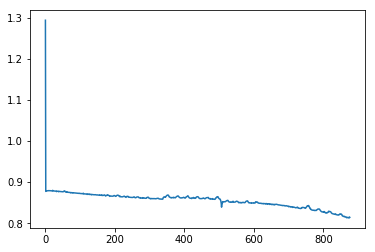

In [58]:
plt.plot(struct.summary.cycle_index, struct.summary.energy_efficiency)